In [2]:
import numpy as np
import pandas as pd
from EMDPM.model_generator import generate_logistic_model
from EMDPM.synthetic_data_generator import generate_synthetic_data
from EMDPM.visualization import (
    plot_biomarker_trajectories,
    plot_true_observations,
    plot_initial_beta_guess,
    plot_theta_fit_comparison,
    plot_theta_error_history,
    plot_beta_overlay,
    plot_beta_error_history,
    plot_lse,
    plot_cog_regression_history
    
    
)
from EMDPM.utils import solve_system
from EMDPM.em_transformer_rework import EM
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

from sklearn.model_selection import GroupKFold, GridSearchCV



In [3]:
df = pd.read_csv("/data01/bgutman/MRI_data/PPMI/data_ppmi_pd.csv")
df_K = pd.read_csv("/data01/bgutman/LEGACY/Skoltech/datasets/Connectomes/mean_NORM_con_22.csv")
n_biomarkers = 10

## remove non-longitudinal observations
print("original size:", df.shape)
relevant_cols = [col for col in df.columns if col.startswith(('L_', 'R_')) and ('_thickavg' in col or '_thickavg_resid' in col)]
relevant_cols += ["MCATOT", "TD_score", "PIGD_score"]
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=relevant_cols)

print("after drop na", df.shape)
subj_counts = df['subj_id'].value_counts()
num_unique = (subj_counts == 1).sum()
print("one time subj_id:", num_unique)

longitudinal_ids = subj_counts[subj_counts > 1].index
df = df[df['subj_id'].isin(longitudinal_ids)].copy()
df = df.drop_duplicates(subset=["subj_id", "time"])
print("after drop dupes", df.shape)

small_region_set = ['L_inferiorparietal_thickavg','R_inferiorparietal_thickavg','L_inferiortemporal_thickavg','R_inferiortemporal_thickavg',
'L_precuneus_thickavg','R_precuneus_thickavg','L_isthmuscingulate_thickavg','R_isthmuscingulate_thickavg','L_lateraloccipital_thickavg','R_lateraloccipital_thickavg']

small_region_set_resid = ['L_inferiorparietal_thickavg_resid','R_inferiorparietal_thickavg_resid','L_inferiortemporal_thickavg_resid','R_inferiortemporal_thickavg_resid',
'L_precuneus_thickavg_resid','R_precuneus_thickavg_resid','L_isthmuscingulate_thickavg_resid','R_isthmuscingulate_thickavg_resid','L_lateraloccipital_thickavg_resid','R_lateraloccipital_thickavg_resid']

X_obs = df[[col for col in df.columns if (col.startswith(('L_', 'R_')) and col.endswith('_thickavg') and not col.endswith('_thickavg_resid'))]]
X_obs_resid = df[small_region_set_resid]
X_obs_resid = X_obs_resid.to_numpy()
X_obs_resid = np.max(X_obs_resid, axis=0) - X_obs_resid

#X_obs = df[small_region_set]
X_obs = X_obs.to_numpy()
X_obs = np.max(X_obs, axis=0) - X_obs


print("nans in X:", np.isnan(X_obs).sum())
print("infs in X:", np.isinf(X_obs).sum())

print("nans X_resid:", np.isnan(X_obs_resid).sum())
print("infs X_resid:", np.isinf(X_obs_resid).sum())

## connectivity matrix to numpy
K = df_K.drop(df_K.columns[0], axis=1).to_numpy()
np.fill_diagonal(K, 0)
print(K.shape, type(K))

# normalization
row_sums = K.sum(axis=1)
median_row_sum = np.median(row_sums)
K = K / median_row_sum

region_index = [6, 40, 7, 41, 23, 57, 8, 42, 9, 43]
#K = np.take(np.take(K,region_index,axis=0), region_index, axis=1)

t_max = 30
step = 0.001
print("X.size: ", X_obs.shape, "X_resid.size: ", X_obs_resid.shape)

ids = df["subj_id"].to_numpy()
dt = df["time"].to_numpy()/12 # convert to years
#cog = df["MCATOT"].values#,"TD_score","PIGD_score"]].values
cog = df[["MCATOT","TD_score","PIGD_score"]].to_numpy()
nhy = df["NHY"].to_numpy()
print("nans in cog:", np.isnan(cog).sum())
print("infs in cog:", np.isinf(cog).sum())


original size: (880, 250)
after drop na (868, 250)
one time subj_id: 227
after drop dupes (504, 250)
nans in X: 0
infs in X: 0
nans X_resid: 0
infs X_resid: 0
(68, 68) <class 'numpy.ndarray'>
X.size:  (504, 68) X_resid.size:  (504, 10)
nans in cog: 0
infs in cog: 0


/home/dsemchin/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dsemchin/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/dsemchin/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dsemchin/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/dsemchin/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

(array([ 1.,  0.,  2.,  4.,  1.,  7., 17., 36., 56., 22.]),
 array([ 0.        ,  3.03916505,  6.07833011,  9.11749516, 12.15666021,
        15.19582527, 18.23499032, 21.27415537, 24.31332043, 27.35248548,
        30.39165053]),
 <BarContainer object of 10 artists>)

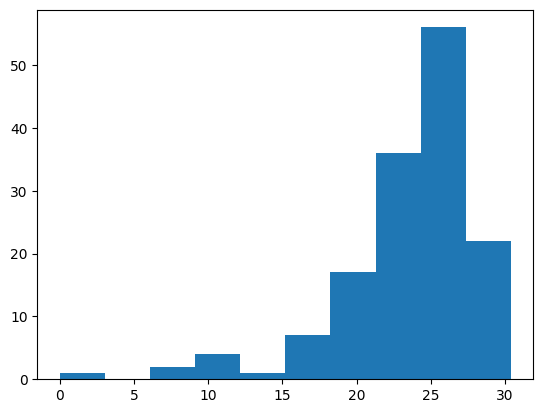

In [4]:
def compute_patient_avg_slope(X, dt, ids):
    unique_ids = np.unique(ids)
    pid_to_slope = {}
    
    for pid in unique_ids:
        mask = (ids == pid)
        t = dt[mask].reshape(-1,1)
        Xi = X[mask]                       
        if Xi.shape[0] < 2:
            pid_to_slope[pid] = 0.0
            continue
        
        slopes = []
        for j in range(Xi.shape[1]):
            y = Xi[:, j]
            # simple linear fit: biomarker_j = a * dt + b
            a = np.linalg.lstsq(np.hstack([t, np.ones_like(t)]), y, rcond=None)[0][0]
            slopes.append(a)
        pid_to_slope[pid] = np.mean(slopes)
        
    return pid_to_slope

def prepare_glm_data(df, X, dt, ids, cog_df):
    df_proc = df.copy()
    df_proc['dt'] = dt
    df_proc['id'] = ids
    
    df_proc['dt_min'] = df_proc.groupby('id')['dt'].transform('min')
    df_proc['dt_max'] = df_proc.groupby('id')['dt'].transform('max')
    df_proc['dt_scaled'] = (df_proc['dt'] - df_proc['dt_min']) / (df_proc['dt_max'] - df_proc['dt_min'] + 1e-8)
    
    df_proc[['MCATOT','PIGD_score','TD_score']] = cog_df[['MCATOT','PIGD_score','TD_score']]
    
    pid_to_slope = compute_patient_avg_slope(X, dt, ids)
    df_proc['avg_slope'] = df_proc['id'].map(pid_to_slope)
    
    return df_proc

def init_beta_mixedlm(df_proc, t_max):
    # Use dt_scaled as response; random intercept on 'id'
    model = smf.mixedlm("dt_scaled ~ MCATOT + PIGD_score + TD_score + avg_slope",
                         data=df_proc,
                         groups=df_proc["id"],
                         re_formula="1")
    result = model.fit()
    
    # intercepts
    rand_eff = result.random_effects  # dict pid->{'Group': val}
    pid_to_beta = {pid: eff["Group"] * t_max for pid, eff in rand_eff.items()}
    return pid_to_beta

df_proc = prepare_glm_data(df=df, X=X_obs, dt=dt, ids=ids, cog_df=df[["MCATOT","PIGD_score","TD_score"]])

pid_to_beta = init_beta_mixedlm(df_proc, t_max=t_max)
unique_ids = np.unique(ids)
beta_init = np.array([pid_to_beta.get(pid, 0.0) for pid in unique_ids])

initial_beta = (beta_init + np.abs(min(beta_init)))*1.5e5
plt.hist(initial_beta)

In [5]:
def create_patient_list(X_obs, ids, dt, cog, initial_beta=None):
    unique_ids = np.unique(ids)
    id_to_index = {pid: idx for idx, pid in enumerate(unique_ids)}

    patient_list = []
    for pid in unique_ids:
        mask = (ids == pid)
        patient_data = {
            "id": pid,
            "X_obs": X_obs[mask],
            "dt": dt[mask],
            "cog": cog[mask],
        }
        if initial_beta is not None:
            patient_data["initial_beta"] = initial_beta[id_to_index[pid]]
        patient_list.append(patient_data)

    return patient_list

X = create_patient_list(X_obs, ids, dt, cog, initial_beta)

In [ ]:
# there are 504 obs and ~150 patients
# X = {
#     "X_obs": X_obs,       # (n_obs, n_biomarkers)
#     "dt": dt,             # (n_obs,)
#     "ids": ids,           # (n_obs,)
#     "cog": cog,           # (n_obs, n_cog_features)
#     "K": K,               # (n_biomarkers, n_biomarkers)
#     "initial_beta": initial_beta  # (n_patients,)
# }
from sklearn.metrics import make_scorer

# Define this in a code cell before GridSearchCV
def unsupervised_em_scorer(estimator, X, y=None):
    try:
        score = estimator.score(X)
        print(f"[GridSearchCV] score = {score:.4f}")
        return score
    except Exception as e:
        print(f"[GridSearchCV ERROR]: {e}")
        return float("-inf")

unsupervised_scorer = make_scorer(unsupervised_em_scorer, greater_is_better=True)



model = EM(K=K)
param_grid = {
    "lambda_f": [0.01, 0.1, 0.3, 0.5, 0.7, 1.0],
    "lambda_cog": [0.01, 0.1, 0.3, 0.5, 0.7, 1.0],
    "lambda_scalar": [0.01, 0.1, 0.3, 0.5, 0.7, 1.0],
    "jac_toggle": [True],
    "max_iter": [20],
}
groups = [p["id"] for p in X]

gkf = GroupKFold(n_splits=3)
grid = GridSearchCV(model, param_grid, cv=gkf, scoring = None, n_jobs=15)#scoring=unsupervised_scorer)
grid.fit(X=X, y=None, groups=groups);

print("Best score:", grid.best_score_)
print("Best params:", grid.best_params_)


 10%|█         | 2/20 [00:00<00:05,  3.19it/s]

 10%|█         | 2/20 [00:00<00:06,  2.71it/s]

 85%|████████▌ | 17/20 [00:17<00:02,  1.09it/s]

 90%|█████████ | 18/20 [00:26<00:07,  3.78s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.42it/s]]

 25%|██▌       | 5/20 [00:34<01:35,  6.35s/it]

 30%|███       | 6/20 [00:34<01:02,  4.43s/it]

 15%|█▌        | 3/20 [00:35<04:31, 15.98s/it]

 20%|██        | 4/20 [00:38<02:52, 10.77s/it]

 25%|██▌       | 5/20 [00:40<01:49,  7.30s/it]

 25%|██▌       | 5/20 [00:43<01:59,  7.98s/it]

 25%|██▌       | 5/20 [00:44<02:01,  8.10s/it]

 20%|██        | 4/20 [00:45<03:20, 12.52s/it]

 25%|██▌       | 5/20 [00:46<02:05,  8.36s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  5%|▌         | 1/20 [00:00<00:05,  3.61it/s]

 10%|█         | 2/20 [00:00<00:05,  3.15it/s]

 95%|█████████▌| 19/20 [00:54<00:10, 10.59s/it]

 15%|█▌        | 3/20 [00:56<07:14, 25.55s/it]

 95%|█████████▌| 19/20 [00:59<00:03,  3.11s/it]


L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.01it/s]

 15%|█▌        | 3/20 [01:04<08:17, 29.25s/it]

 20%|██        | 4/20 [01:05<04:50, 18.17s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 25%|██▌       | 5/20 [01:06<03:00, 12.05s/it]

 25%|██▌       | 5/20 [00:39<01:46,  7.12s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:06,  2.82it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.46it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.21it/s]

 30%|███       | 6/20 [01:15<03:37, 15.53s/it]

 20%|██        | 4/20 [00:27<02:02,  7.65s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 25%|██▌       | 5/20 [00:28<01:20,  5.38s/it]

 45%|████▌     | 9/20 [01:18<01:00,  5.54s/it]

 55%|█████▌    | 11/20 [01:20<00:28,  3.14s/it]

 25%|██▌       | 5/20 [01:24<03:47, 15.14s/it]

 20%|██        | 4/20 [01:30<06:38, 24.94s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 25%|██▌       | 5/20 [01:31<04:05, 16.40s/it]

 20%|██        | 4/20 [00:44<03:19, 12.48s/it]

 25%|██▌       | 5/20 [00:46<02:05,  8.38s/it]

 40%|████      | 8/20 [01:39<03:11, 15.97s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.08it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.23it/s]

 30%|███       | 6/20 [01:03<03:33, 15.24s/it]

 15%|█▌        | 3/20 [00:59<07:43, 27.27s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.13it/s]

 30%|███       | 6/20 [01:02<01:46,  7.60s/it]

 30%|███       | 6/20 [00:52<01:29,  6.37s/it]

 65%|██████▌   | 13/20 [02:08<01:22, 11.78s/it]

 30%|███       | 6/20 [01:19<03:57, 16.93s/it]

 25%|██▌       | 5/20 [00:53<02:24,  9.64s/it]

 30%|███       | 6/20 [02:13<05:52, 25.15s/it]]

 35%|███▌      | 7/20 [02:14<03:44, 17.30s/it]

 55%|█████▌    | 11/20 [01:26<00:35,  3.94s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.18it/s]

 35%|███▌      | 7/20 [01:51<04:17, 19.80s/it]

 15%|█▌        | 3/20 [00:50<06:33, 23.17s/it]

 25%|██▌       | 5/20 [00:52<02:22,  9.47s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.53it/s]

 40%|████      | 8/20 [02:29<03:50, 19.22s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:04,  3.61it/s]

 60%|██████    | 12/20 [01:47<01:12,  9.11s/it]

 40%|████      | 8/20 [01:25<01:35,  7.96s/it]]

 60%|██████    | 12/20 [01:25<00:29,  3.63s/it]

 40%|████      | 8/20 [01:29<01:41,  8.44s/it]]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.11it/s]]

 60%|██████    | 12/20 [01:29<00:20,  2.61s/it]

 65%|██████▌   | 13/20 [01:31<00:15,  2.20s/it]

 35%|███▌      | 7/20 [01:27<02:36, 12.02s/it]]

 15%|█▌        | 3/20 [00:21<02:48,  9.90s/it]]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  5%|▌         | 1/20 [00:00<00:05,  3.28it/s]

 10%|█         | 2/20 [00:00<00:05,  3.07it/s]]

 20%|██        | 4/20 [00:23<01:43,  6.50s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 30%|███       | 6/20 [01:18<03:30, 15.06s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 50%|█████     | 10/20 [01:05<00:35,  3.56s/it]

 40%|████      | 8/20 [01:20<01:28,  7.39s/it]

 45%|████▌     | 9/20 [01:21<00:59,  5.44s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 70%|███████   | 14/20 [01:41<00:28,  4.75s/it]

 55%|█████▌    | 11/20 [01:23<00:28,  3.17s/it]

 55%|█████▌    | 11/20 [01:50<01:25,  9.46s/it]

 25%|██▌       | 5/20 [00:58<02:36, 10.46s/it]]

 65%|██████▌   | 13/20 [01:52<00:36,  5.14s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  5%|▌         | 1/20 [00:00<00:06,  2.91it/s]

 10%|█         | 2/20 [00:00<00:06,  2.87it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.18it/s]

 15%|█▌        | 3/20 [00:32<04:10, 14.76s/it]

 50%|█████     | 10/20 [00:11<00:12,  1.24s/it]

 65%|██████▌   | 13/20 [00:13<00:06,  1.04it/s]

 45%|████▌     | 9/20 [00:42<00:27,  2.46s/it]

 45%|████▌     | 9/20 [01:45<01:28,  8.01s/it]]

 55%|█████▌    | 11/20 [01:46<00:38,  4.23s/it]

 50%|█████     | 10/20 [01:06<00:54,  5.48s/it]

 35%|███▌      | 7/20 [01:14<01:56,  8.94s/it]]

 40%|████      | 8/20 [01:15<01:16,  6.36s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.54it/s]

 45%|████▌     | 9/20 [01:16<00:51,  4.65s/it]]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:06,  2.97it/s]]

 15%|█▌        | 3/20 [00:44<05:40, 20.04s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 25%|██▌       | 5/20 [00:45<02:02,  8.20s/it]

 20%|██        | 4/20 [00:48<03:36, 13.52s/it]

 25%|██▌       | 5/20 [00:49<02:16,  9.08s/it]

 25%|██▌       | 5/20 [00:57<02:34, 10.32s/it]

 25%|██▌       | 5/20 [01:01<02:46, 11.07s/it]]

 70%|███████   | 14/20 [01:11<00:18,  3.01s/it]

 35%|███▌      | 7/20 [01:06<02:20, 10.80s/it]]

 40%|████      | 8/20 [01:07<01:32,  7.72s/it]]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:04,  3.62it/s]]

 45%|████▌     | 9/20 [01:09<01:03,  5.78s/it]]

 50%|█████     | 10/20 [01:11<00:46,  4.63s/it]

 45%|████▌     | 9/20 [01:08<00:59,  5.37s/it]]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 40%|████      | 8/20 [01:30<02:18, 11.57s/it]]

 80%|████████  | 16/20 [02:24<00:24,  6.00s/it]

 80%|████████  | 16/20 [01:03<00:53, 13.31s/it]

 35%|███▌      | 7/20 [01:16<02:14, 10.32s/it]

 65%|██████▌   | 13/20 [01:37<00:21,  3.08s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  5%|▌         | 1/20 [00:00<00:05,  3.52it/s]

 45%|████▌     | 9/20 [01:19<01:00,  5.54s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:04,  3.92it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 55%|█████▌    | 11/20 [01:15<00:28,  3.19s/it]

 15%|█▌        | 3/20 [00:39<05:03, 17.83s/it]]

 15%|█▌        | 3/20 [00:44<05:45, 20.32s/it]]

 20%|██        | 4/20 [00:45<03:23, 12.71s/it]

 75%|███████▌  | 15/20 [01:49<00:22,  4.44s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.48it/s]

 35%|███▌      | 7/20 [00:59<01:06,  5.08s/it]

 30%|███       | 6/20 [01:00<02:24, 10.31s/it]]

 70%|███████   | 14/20 [01:51<00:17,  2.92s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  0%|          | 0/20 [00:00<?, ?it/s]

 10%|█         | 2/20 [00:00<00:04,  3.90it/s]]

 60%|██████    | 12/20 [01:52<00:27,  3.45s/it]

 60%|██████    | 12/20 [01:07<00:17,  2.14s/it]

 65%|██████▌   | 13/20 [01:55<00:21,  3.11s/it]

 50%|█████     | 10/20 [00:54<00:27,  2.73s/it]

 55%|█████▌    | 11/20 [01:17<00:30,  3.43s/it]

 55%|█████▌    | 11/20 [01:13<00:34,  3.83s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  5%|▌         | 1/20 [00:00<00:06,  3.11it/s]]

 65%|██████▌   | 13/20 [00:57<00:10,  1.56s/it]

 70%|███████   | 14/20 [00:58<00:08,  1.50s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:04,  3.72it/s]]

 80%|████████  | 16/20 [01:00<00:04,  1.15s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  5%|▌         | 1/20 [00:00<00:04,  3.86it/s]

 80%|████████  | 16/20 [02:08<00:20,  5.04s/it]

 20%|██        | 4/20 [00:47<03:29, 13.11s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  0%|          | 0/20 [00:00<?, ?it/s]

 10%|█         | 2/20 [00:00<00:06,  2.86it/s]

 30%|███       | 6/20 [00:41<01:13,  5.22s/it]

 40%|████      | 8/20 [01:05<01:17,  6.50s/it]]

 90%|█████████ | 18/20 [01:15<00:07,  3.94s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 55%|█████▌    | 11/20 [01:09<00:26,  2.93s/it]

 10%|█         | 2/20 [00:00<00:05,  3.15it/s]

 55%|█████▌    | 11/20 [01:05<00:29,  3.28s/it]

 35%|███▌      | 7/20 [01:04<01:41,  7.82s/it]]

 30%|███       | 6/20 [00:40<01:21,  5.82s/it]]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:04,  3.72it/s]

 30%|███       | 6/20 [00:43<01:41,  7.24s/it]]


L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 60%|██████    | 12/20 [01:21<00:46,  5.86s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:06,  2.96it/s]

 70%|███████   | 14/20 [01:50<01:05, 10.90s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 55%|█████▌    | 11/20 [01:13<00:33,  3.68s/it]

 40%|████      | 8/20 [01:03<01:27,  7.29s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  5%|▌         | 1/20 [00:00<00:06,  3.01it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 40%|████      | 8/20 [01:16<01:50,  9.20s/it]

 10%|█         | 2/20 [00:00<00:05,  3.42it/s]]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:04,  3.66it/s]

 55%|█████▌    | 11/20 [01:19<00:33,  3.73s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 60%|██████    | 12/20 [01:22<00:26,  3.28s/it]

 15%|█▌        | 3/20 [00:44<05:42, 20.15s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.36it/s]

 20%|██        | 4/20 [00:45<03:23, 12.71s/it]

 30%|███       | 6/20 [00:46<01:20,  5.76s/it]]

 60%|██████    | 12/20 [01:19<00:39,  4.99s/it]

 25%|██▌       | 5/20 [00:47<02:07,  8.53s/it]

 25%|██▌       | 5/20 [00:34<01:33,  6.27s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:04,  3.68it/s]

 20%|██        | 4/20 [00:43<03:15, 12.20s/it]

 15%|█▌        | 3/20 [00:42<05:28, 19.33s/it]

 35%|███▌      | 7/20 [01:10<02:01,  9.32s/it]

 25%|██▌       | 5/20 [00:46<02:06,  8.43s/it]]

 30%|███       | 6/20 [00:47<01:22,  5.92s/it]]

 20%|██        | 4/20 [00:38<02:49, 10.62s/it]]

 45%|████▌     | 9/20 [01:23<01:23,  7.57s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 20%|██        | 4/20 [00:47<03:29, 13.11s/it]]

 65%|██████▌   | 13/20 [01:23<00:20,  2.91s/it]

 45%|████▌     | 9/20 [00:58<00:56,  5.18s/it]

 60%|██████    | 12/20 [01:28<00:28,  3.56s/it]

 50%|█████     | 10/20 [00:59<00:39,  3.93s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  0%|          | 0/20 [00:00<?, ?it/s]

 10%|█         | 2/20 [00:00<00:05,  3.37it/s]]

 60%|██████    | 12/20 [01:04<00:27,  3.43s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:04,  3.62it/s]

 45%|████▌     | 9/20 [00:59<01:02,  5.71s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.13it/s]]

 35%|███▌      | 7/20 [00:57<01:46,  8.21s/it]]

 50%|█████     | 10/20 [01:22<00:56,  5.60s/it]

 15%|█▌        | 3/20 [00:40<05:11, 18.30s/it]]

 60%|██████    | 12/20 [01:09<00:36,  4.55s/it]

 35%|███▌      | 7/20 [01:08<02:16, 10.52s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 45%|████▌     | 9/20 [01:04<01:15,  6.84s/it]

 50%|█████     | 10/20 [01:13<00:47,  4.75s/it]

 40%|████      | 8/20 [01:19<02:34, 12.85s/it]]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:06,  2.91it/s]

 55%|█████▌    | 11/20 [01:23<00:45,  5.07s/it]

 35%|███▌      | 7/20 [01:22<03:25, 15.80s/it]

 60%|██████    | 12/20 [01:14<00:40,  5.10s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 65%|██████▌   | 13/20 [01:15<00:27,  3.93s/it]

 65%|██████▌   | 13/20 [01:25<00:56,  8.06s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 70%|███████   | 14/20 [01:26<00:35,  5.90s/it]

 10%|█         | 2/20 [00:00<00:04,  3.68it/s]

 25%|██▌       | 5/20 [00:43<02:00,  8.02s/it]]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 45%|████▌     | 9/20 [01:06<01:16,  6.92s/it]

 40%|████      | 8/20 [00:45<00:35,  3.00s/it]]

 55%|█████▌    | 11/20 [01:08<00:34,  3.85s/it]

 20%|██        | 4/20 [00:26<02:00,  7.50s/it]]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  0%|          | 0/20 [00:00<?, ?it/s]

 10%|█         | 2/20 [00:00<00:05,  3.01it/s]]

 30%|███       | 6/20 [00:28<00:51,  3.66s/it]]

 15%|█▌        | 3/20 [00:43<05:36, 19.81s/it]]

 20%|██        | 4/20 [00:44<03:17, 12.37s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 65%|██████▌   | 13/20 [01:38<01:25, 12.27s/it]

 15%|█▌        | 3/20 [00:44<05:40, 20.05s/it]

 20%|██        | 4/20 [00:45<03:20, 12.54s/it]

 70%|███████   | 14/20 [01:39<01:00, 10.11s/it]

 40%|████      | 8/20 [00:58<01:04,  5.41s/it]]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 25%|██▌       | 5/20 [00:46<02:06,  8.45s/it]]

 30%|███       | 6/20 [00:47<01:24,  6.06s/it]]

 35%|███▌      | 7/20 [00:48<00:55,  4.30s/it]]

 65%|██████▌   | 13/20 [01:04<00:12,  1.79s/it]

 55%|█████▌    | 11/20 [00:51<00:30,  3.44s/it]

  0%|          | 0/20 [00:00<?, ?it/s].03s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.57it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.59it/s]]

 20%|██        | 4/20 [00:40<03:00, 11.29s/it]]

 40%|████      | 8/20 [00:50<00:53,  4.47s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.31it/s]

 20%|██        | 4/20 [00:40<02:58, 11.16s/it]]

 75%|███████▌  | 15/20 [02:16<01:30, 18.13s/it]

 35%|███▌      | 7/20 [00:43<00:51,  3.97s/it]]

 50%|█████     | 10/20 [01:18<01:02,  6.22s/it]

 75%|███████▌  | 15/20 [01:32<00:34,  6.95s/it]

 55%|█████▌    | 11/20 [01:19<00:41,  4.62s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 30%|███       | 6/20 [00:27<00:48,  3.45s/it]

 60%|██████    | 12/20 [01:20<00:28,  3.54s/it]

 35%|███▌      | 7/20 [00:27<00:33,  2.56s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:04,  3.64it/s]

 25%|██▌       | 5/20 [00:39<01:46,  7.13s/it]]

 35%|███▌      | 7/20 [00:41<00:48,  3.75s/it]]

 90%|█████████ | 18/20 [01:39<00:13,  6.76s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.15it/s]

 85%|████████▌ | 17/20 [02:35<00:41, 13.88s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.52it/s]

 45%|████▌     | 9/20 [01:22<01:23,  7.57s/it]]

 15%|█▌        | 3/20 [00:42<05:28, 19.31s/it]]

 20%|██        | 4/20 [00:44<03:16, 12.29s/it]]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:04,  3.97it/s]]

 70%|███████   | 14/20 [01:31<00:56,  9.35s/it]

 45%|████▌     | 9/20 [01:11<01:28,  8.09s/it]]

 75%|███████▌  | 15/20 [01:44<00:58, 11.76s/it]

 20%|██        | 4/20 [00:39<02:57, 11.07s/it]]

 60%|██████    | 12/20 [01:26<00:42,  5.33s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  5%|▌         | 1/20 [00:00<00:06,  2.76it/s]

 60%|██████    | 12/20 [01:33<00:40,  5.02s/it]

 65%|██████▌   | 13/20 [01:34<00:27,  3.88s/it]

 45%|████▌     | 9/20 [00:31<00:20,  1.87s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence
L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.19it/s]

 75%|███████▌  | 15/20 [00:59<00:23,  4.66s/it]

 15%|█▌        | 3/20 [00:02<00:20,  1.19s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.11it/s]

 70%|███████   | 14/20 [01:38<00:31,  5.25s/it]

 70%|███████   | 14/20 [01:40<00:43,  7.20s/it]


L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.47it/s]

 55%|█████▌    | 11/20 [00:11<00:09,  1.10s/it]

 50%|█████     | 10/20 [01:10<00:51,  5.16s/it]

 70%|███████   | 14/20 [01:34<00:36,  6.05s/it]

 60%|██████    | 12/20 [01:12<00:24,  3.05s/it]

 20%|██        | 4/20 [00:37<02:47, 10.47s/it]

 25%|██▌       | 5/20 [00:38<01:46,  7.12s/it]]

 40%|████      | 8/20 [00:37<00:30,  2.56s/it]

 45%|████▌     | 9/20 [00:38<00:21,  1.98s/it]]

 75%|███████▌  | 15/20 [01:19<00:11,  2.28s/it]

 75%|███████▌  | 15/20 [00:27<00:17,  3.50s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 20%|██        | 4/20 [00:42<03:08, 11.77s/it]

 35%|███▌      | 7/20 [00:45<00:53,  4.13s/it]]

 65%|██████▌   | 13/20 [01:05<00:56,  8.09s/it]

 70%|███████   | 14/20 [01:06<00:35,  5.94s/it]

 20%|██        | 4/20 [00:42<03:08, 11.77s/it]]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.18it/s]]

 15%|█▌        | 3/20 [00:03<00:21,  1.28s/it]]

 70%|███████   | 14/20 [01:09<00:11,  1.88s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  5%|▌         | 1/20 [00:00<00:05,  3.21it/s]]

 20%|██        | 4/20 [00:43<03:12, 12.03s/it]

 25%|██▌       | 5/20 [00:33<01:33,  6.25s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  5%|▌         | 1/20 [00:00<00:05,  3.43it/s]

 95%|█████████▌| 19/20 [02:06<00:06,  6.95s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:06,  2.93it/s]]

 85%|████████▌ | 17/20 [01:16<00:05,  1.86s/it]

 60%|██████    | 12/20 [00:11<00:07,  1.06it/s]

 10%|█         | 2/20 [00:00<00:04,  3.73it/s]]

 80%|████████  | 16/20 [00:14<00:03,  1.19it/s]

 25%|██▌       | 5/20 [00:14<00:42,  2.86s/it]]

 45%|████▌     | 9/20 [00:18<00:14,  1.30s/it]]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 65%|██████▌   | 13/20 [01:01<00:13,  1.91s/it]

 50%|█████     | 10/20 [01:14<00:59,  5.93s/it]

 55%|█████▌    | 11/20 [01:15<00:39,  4.39s/it]

 55%|█████▌    | 11/20 [01:10<00:44,  5.00s/it]

 15%|█▌        | 3/20 [00:37<04:48, 16.99s/it]]

 20%|██        | 4/20 [00:38<02:49, 10.60s/it]]

  0%|          | 0/20 [00:00<?, ?it/s].81s/it]

 10%|█         | 2/20 [00:00<00:05,  3.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 25%|██▌       | 5/20 [00:22<01:04,  4.31s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 30%|███       | 6/20 [00:41<01:13,  5.22s/it]

 10%|█         | 2/20 [00:00<00:06,  2.90it/s]]

 40%|████      | 8/20 [00:26<00:26,  2.18s/it]]

 30%|███       | 6/20 [00:06<00:15,  1.12s/it]]

 35%|███▌      | 7/20 [00:07<00:15,  1.16s/it]

 90%|█████████ | 18/20 [01:18<00:05,  2.64s/it]

 50%|█████     | 10/20 [00:10<00:10,  1.03s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.07it/s]]

 65%|██████▌   | 13/20 [00:13<00:06,  1.09it/s]

 20%|██        | 4/20 [00:37<02:47, 10.46s/it]]

 25%|██▌       | 5/20 [00:04<00:15,  1.03s/it]]

 20%|██        | 4/20 [00:33<02:28,  9.29s/it]

 45%|████▌     | 9/20 [00:38<00:22,  2.03s/it]]

 50%|█████     | 10/20 [00:10<00:09,  1.01it/s]

 50%|█████     | 10/20 [01:04<01:01,  6.12s/it]

 75%|███████▌  | 15/20 [00:14<00:04,  1.03it/s]

 15%|█▌        | 3/20 [00:13<01:41,  5.95s/it]]

 30%|███       | 6/20 [00:15<00:29,  2.11s/it]]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 15%|█▌        | 3/20 [00:38<04:59, 17.60s/it]]

 30%|███       | 6/20 [00:30<00:53,  3.82s/it]

 40%|████      | 8/20 [00:31<00:26,  2.21s/it]]

 45%|████▌     | 9/20 [00:32<00:19,  1.74s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  5%|▌         | 1/20 [00:00<00:06,  3.11it/s]

 35%|███▌      | 7/20 [00:43<00:51,  3.95s/it]

 40%|████      | 8/20 [00:44<00:35,  2.96s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 40%|████      | 8/20 [00:37<00:31,  2.60s/it]]

 90%|█████████ | 18/20 [00:41<00:12,  6.14s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 90%|█████████ | 18/20 [02:07<00:19,  9.89s/it]

 65%|██████▌   | 13/20 [00:47<00:15,  2.22s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.38it/s]]

 15%|█▌        | 3/20 [00:12<01:36,  5.66s/it]

 60%|██████    | 12/20 [01:13<00:34,  4.29s/it]

 20%|██        | 4/20 [00:13<01:01,  3.86s/it]]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 80%|████████  | 16/20 [01:18<00:34,  8.57s/it]

 20%|██        | 4/20 [00:03<00:17,  1.10s/it]

 25%|██▌       | 5/20 [00:04<00:14,  1.01it/s]]

 45%|████▌     | 9/20 [00:18<00:13,  1.23s/it]]

 25%|██▌       | 5/20 [00:04<00:15,  1.04s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  0%|          | 0/20 [00:00<?, ?it/s]6.03s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:04,  3.65it/s]]

 55%|█████▌    | 11/20 [01:06<00:41,  4.56s/it]

 70%|███████   | 14/20 [00:57<00:12,  2.06s/it]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


  5%|▌         | 1/20 [00:00<00:05,  3.26it/s]]

 20%|██        | 4/20 [00:03<00:16,  1.01s/it]]

 25%|██▌       | 5/20 [00:04<00:13,  1.14it/s]]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 50%|█████     | 10/20 [00:10<00:11,  1.17s/it]

 55%|█████▌    | 11/20 [00:11<00:09,  1.04s/it]

 15%|█▌        | 3/20 [00:14<01:48,  6.39s/it]]

 40%|████      | 8/20 [00:07<00:12,  1.02s/it]]

 40%|████      | 8/20 [00:06<00:09,  1.20it/s]]

 70%|███████   | 14/20 [00:13<00:06,  1.02s/it]

  5%|▌         | 1/20 [00:00<00:04,  4.51it/s]]

 10%|█         | 2/20 [00:00<00:04,  3.64it/s]]

 80%|████████  | 16/20 [00:14<00:03,  1.17it/s]

 70%|███████   | 14/20 [00:13<00:06,  1.02s/it]

  5%|▌         | 1/20 [00:00<00:05,  3.52it/s]]

 95%|█████████▌| 19/20 [00:18<00:00,  1.10it/s]

  5%|▌         | 1/20 [00:00<00:05,  3.22it/s]]

 30%|███       | 6/20 [00:06<00:15,  1.13s/it]]

 20%|██        | 4/20 [00:04<00:21,  1.34s/it]]

 25%|██▌       | 5/20 [00:05<00:18,  1.21s/it]

 25%|██▌       | 5/20 [00:05<00:17,  1.17s/it]]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 35%|███▌      | 7/20 [00:07<00:14,  1.10s/it]]

 75%|███████▌  | 15/20 [00:14<00:03,  1.28it/s]

 80%|████████  | 16/20 [00:14<00:03,  1.23it/s]

 60%|██████    | 12/20 [00:11<00:06,  1.15it/s]

  5%|▌         | 1/20 [00:00<00:05,  3.36it/s]]

 65%|██████▌   | 13/20 [00:13<00:06,  1.16it/s]

 70%|███████   | 14/20 [01:02<00:34,  5.72s/it]

 10%|█         | 2/20 [00:00<00:04,  4.14it/s]]

 80%|████████  | 16/20 [00:14<00:03,  1.07it/s]

 65%|██████▌   | 13/20 [00:13<00:06,  1.15it/s]

 40%|████      | 8/20 [00:07<00:09,  1.24it/s]]

 15%|█▌        | 3/20 [00:03<00:27,  1.61s/it]]

 85%|████████▌ | 17/20 [00:16<00:02,  1.17it/s]

 90%|█████████ | 18/20 [00:18<00:01,  1.09it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.38it/s]]

 30%|███       | 6/20 [00:05<00:13,  1.05it/s]]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence
L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 10%|█         | 2/20 [00:00<00:05,  3.39it/s]]

  5%|▌         | 1/20 [00:00<00:05,  3.43it/s]]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 65%|██████▌   | 13/20 [00:11<00:05,  1.27it/s]

 25%|██▌       | 5/20 [00:04<00:14,  1.00it/s]]

 75%|███████▌  | 15/20 [00:15<00:04,  1.15it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 90%|█████████ | 18/20 [00:17<00:01,  1.05it/s]

  5%|▌         | 1/20 [00:00<00:04,  4.50it/s]]

 95%|█████████▌| 19/20 [00:18<00:00,  1.14it/s]

 20%|██        | 4/20 [00:04<00:20,  1.27s/it]]

 15%|█▌        | 3/20 [00:03<00:27,  1.61s/it]]

  0%|          | 0/20 [00:00<?, ?it/s]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 30%|███       | 6/20 [00:06<00:16,  1.15s/it]]

  0%|          | 0/20 [00:00<?, ?it/s].10it/s]

 50%|█████     | 10/20 [00:09<00:08,  1.13it/s]

 10%|█         | 2/20 [00:00<00:04,  3.63it/s]]

  5%|▌         | 1/20 [00:00<00:04,  3.80it/s]]

 20%|██        | 4/20 [00:05<00:23,  1.50s/it]]

 70%|███████   | 14/20 [00:12<00:04,  1.28it/s]

 25%|██▌       | 5/20 [00:06<00:22,  1.47s/it]]

 35%|███▌      | 7/20 [00:07<00:12,  1.01it/s]]

 45%|████▌     | 9/20 [00:09<00:11,  1.06s/it]]

 70%|███████   | 14/20 [00:13<00:05,  1.00it/s]

 95%|█████████▌| 19/20 [00:19<00:00,  1.08it/s]

 75%|███████▌  | 15/20 [00:14<00:04,  1.14it/s]

 80%|████████  | 16/20 [01:31<00:25,  6.46s/it]

 65%|██████▌   | 13/20 [00:12<00:06,  1.13it/s]

 45%|████▌     | 9/20 [00:14<00:11,  1.09s/it]]

 20%|██        | 4/20 [00:11<00:49,  3.12s/it]]

L-BFGS and Nelder-Mead both failed to improve LSE, exiting early due to convergence


 15%|█▌        | 3/20 [00:02<00:19,  1.13s/it]]

 30%|███       | 6/20 [00:13<00:26,  1.88s/it]]

 25%|██▌       | 5/20 [00:04<00:14,  1.03it/s]]

 50%|█████     | 10/20 [00:09<00:09,  1.03it/s]

 75%|███████▌  | 15/20 [00:20<00:04,  1.08it/s]

 65%|██████▌   | 13/20 [00:12<00:06,  1.03it/s]

 95%|█████████▌| 19/20 [00:24<00:00,  1.12it/s]

 85%|████████▌ | 17/20 [00:15<00:02,  1.16it/s]

 10%|█         | 2/20 [00:00<00:05,  3.43it/s]]

 10%|█         | 2/20 [00:00<00:05,  3.59it/s]]

 10%|█         | 2/20 [00:00<00:04,  4.32it/s]]

 15%|█▌        | 3/20 [00:06<00:51,  3.03s/it]]

 10%|█         | 2/20 [00:00<00:04,  3.73it/s]]

 20%|██        | 4/20 [00:20<01:33,  5.83s/it]]

 60%|██████    | 12/20 [00:27<00:09,  1.13s/it]

 95%|█████████▌| 19/20 [00:22<00:01,  1.02s/it]

 75%|███████▌  | 15/20 [00:17<00:04,  1.06it/s]

 75%|███████▌  | 15/20 [00:19<00:04,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 10%|█         | 2/20 [00:00<00:05,  3.08it/s]]

 85%|████████▌ | 17/20 [00:32<00:02,  1.04it/s]

 70%|███████   | 14/20 [00:18<00:06,  1.02s/it]

 15%|█▌        | 3/20 [00:14<01:49,  6.46s/it]]

  5%|▌         | 1/20 [00:00<00:05,  3.30it/s]

 25%|██▌       | 5/20 [00:15<00:44,  2.97s/it]]

 10%|█         | 2/20 [00:00<00:05,  3.20it/s]]

 45%|████▌     | 9/20 [00:19<00:14,  1.35s/it]

 55%|█████▌    | 11/20 [00:20<00:09,  1.07s/it]

 95%|█████████▌| 19/20 [00:26<00:00,  1.06it/s]

 55%|█████▌    | 11/20 [00:22<00:11,  1.28s/it]

 80%|████████  | 16/20 [00:23<00:04,  1.11s/it]

 80%|████████  | 16/20 [00:19<00:03,  1.06it/s]

 90%|█████████ | 18/20 [00:26<00:02,  1.12s/it]

 75%|███████▌  | 15/20 [00:26<00:05,  1.12s/it]

 85%|████████▌ | 17/20 [00:24<00:02,  1.14it/s]

 95%|█████████▌| 19/20 [00:26<00:00,  1.21it/s]

 10%|█         | 2/20 [00:00<00:04,  3.83it/s]]

 30%|███       | 6/20 [00:12<00:25,  1.79s/it]]

 70%|███████   | 14/20 [00:16<00:05,  1.08it/s]

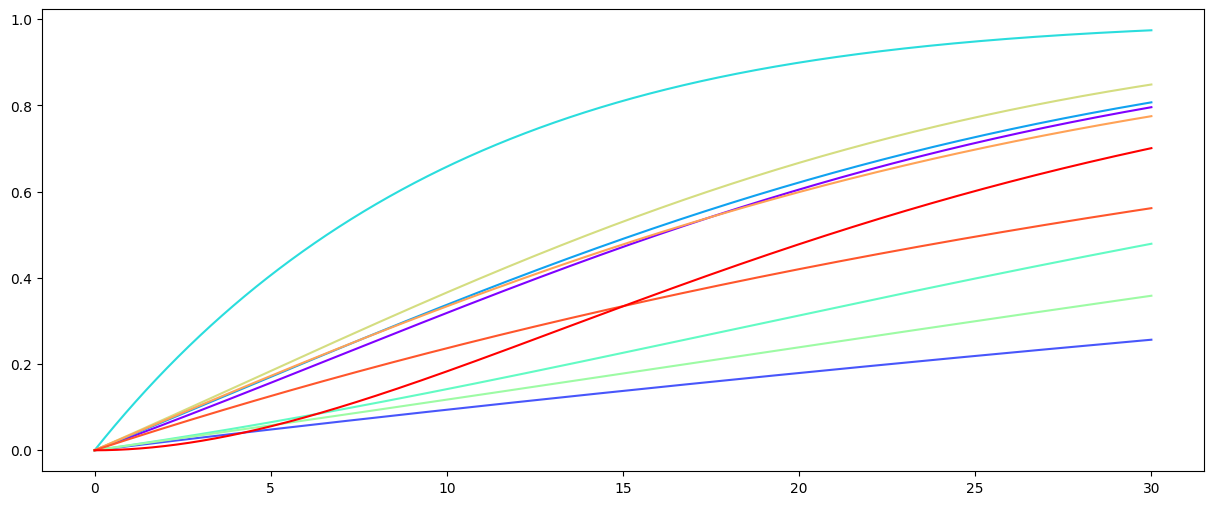

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [1.299 2.487 0.166 0.503 2.96  2.982 2.482 2.546 1.264 2.035]
s_k:  0.9870000000000001
final theta:
f:  [0.03  0.01  0.034 0.102 0.012 0.011 0.036 0.035 0.027 0.   ]
s:  [0.761 2.458 0.779 0.408 1.587 2.009 1.316 1.542 0.994 1.04 ]
s_k:  0.1498418125352666

BETA SUMMARY:
beta initial:  [27.34  14.169 26.668 28.183 25.236 23.508 10.071 23.979 23.418 24.042]
beta final:  [11.726 12.    10.89  10.72  12.    12.    12.    11.134 12.    11.263]


In [ ]:
t_span = np.linspace(0, t_max, int(t_max/step))

best_model = grid.best_estimator_

theta_history = best_model.theta_history
beta_history = best_model.beta_history
lse_history = best_model.lse_history

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

plt.figure(figsize=(15,6))
colors = plt.cm.rainbow(np.linspace(0, 1, n_biomarkers))
for b in range(n_biomarkers):
    plt.plot(t_span, final_model[b], color = colors[b])
plt.show()

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

print("Best score:", grid.best_score_)
print("Best params:", grid.best_params_)

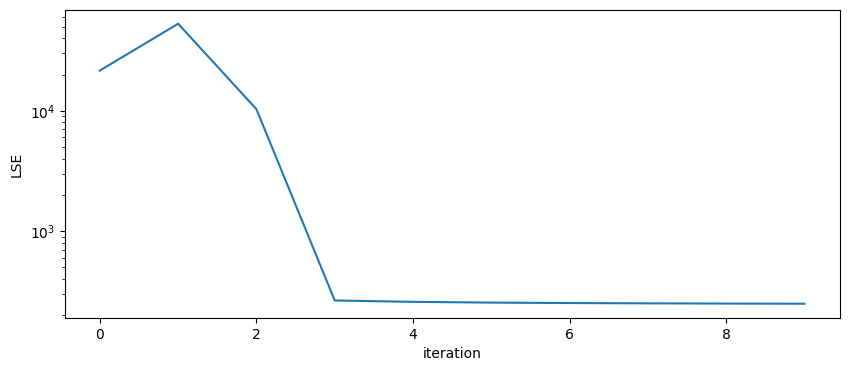

248.7633728713369


In [ ]:
plot_lse(lse_history)
print(lse_history[-1])
# plt.figure()
# plt.plot(lse_history[1:-1])
# plt.yscale('log')
# plt.show()

Unique PIDs: [3102 3105 3107 3108 3111 3113 3116 3118 3119 3120 3122 3123 3124 3125
 3126 3127 3128 3130 3131 3132 3134 3150 3154 3166 3173 3174 3175 3176
 3178 3179 3181 3182 3184 3185 3190 3305 3307 3308 3309 3314 3321 3323
 3325 3327 3328 3352 3354 3359 3360 3364 3365 3366 3367 3371 3372 3373
 3374 3375 3377 3378 3380 3383 3385 3386 3387 3392 3500 3552 3556 3557
 3558 3559 3564 3567 3574 3575 3577 3584 3585 3586 3587 3588 3591 3592
 3593 3752 3757 3758 3760 3762 3763 3770 3771 3775 3776 3777 3778 3780
 3781 3787 3789 3800 3802 3808 3814 3815 3818 3819 3822 3823 3824 3825
 3826 3828 3829 3830 3831 3832 3834 3835 3838 3863 3866 3868 3869 3870
 4001 4005 4011 4012 4013 4019 4020 4021 4022 4024 4025 4026 4027 4029
 4030 4034 4035 4037 4038 4136]
Counts: [2 4 4 4 2 3 3 4 2 4 2 3 4 4 3 2 3 3 3 4 3 3 4 3 3 4 4 2 4 4 3 3 3 3 4 2 4
 4 4 2 3 3 4 4 4 4 4 4 4 4 4 3 4 4 4 4 3 3 4 3 4 2 2 3 4 4 2 4 4 4 3 4 2 4
 3 4 3 2 4 4 3 4 3 3 4 3 4 3 4 3 4 3 2 4 4 4 4 4 3 3 4 4 4 4 4 4 3 4 4 4 4
 4 4 3 4 4 4

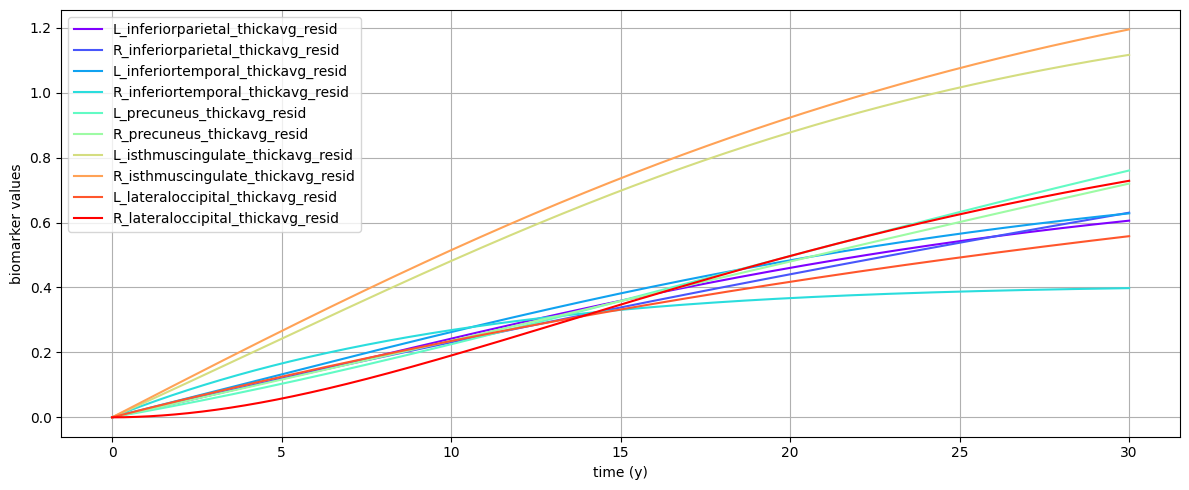

In [ ]:
from sklearn.linear_model import LinearRegression

def plot_trajectories_with_patient_regression(X, dt, ids, beta, t_span, model, patient_id, biomarker_labels=None):

    n_biomarkers = model.shape[0]
    patient_mask = (ids == patient_id)
    
    X_i = X[patient_mask, :]
    print(X_i)
    dt_i = dt[patient_mask]
    beta_i = beta[np.unique(ids).tolist().index(patient_id)]
    t_ij = dt_i + beta_i 
    fig, ax = plt.subplots(figsize=(12, 5))
    
    
    for j in range(n_biomarkers):
        label = biomarker_labels[j]
        color = plt.cm.rainbow(np.linspace(0, 1, n_biomarkers))    

        ax.plot(t_span, model[j], label=label, color=color[j])        

    ax.set_xlabel("time (y)")
    ax.set_ylabel("biomarker values")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

unique_pids, counts = np.unique(ids, return_counts=True)
modal_pid = unique_pids[np.argmax(counts)]

print("Unique PIDs:", unique_pids)
print("Counts:", counts)
print("Modal PID:", modal_pid)

print(len(np.unique(ids)))
print(len(beta_history[:,-1]))
s = final_theta[n_biomarkers:2*n_biomarkers]

plot_trajectories_with_patient_regression(X_obs, dt, ids, beta_history[:,-1], t_span, final_model*s[:,None], ids[5], small_region_set_resid)

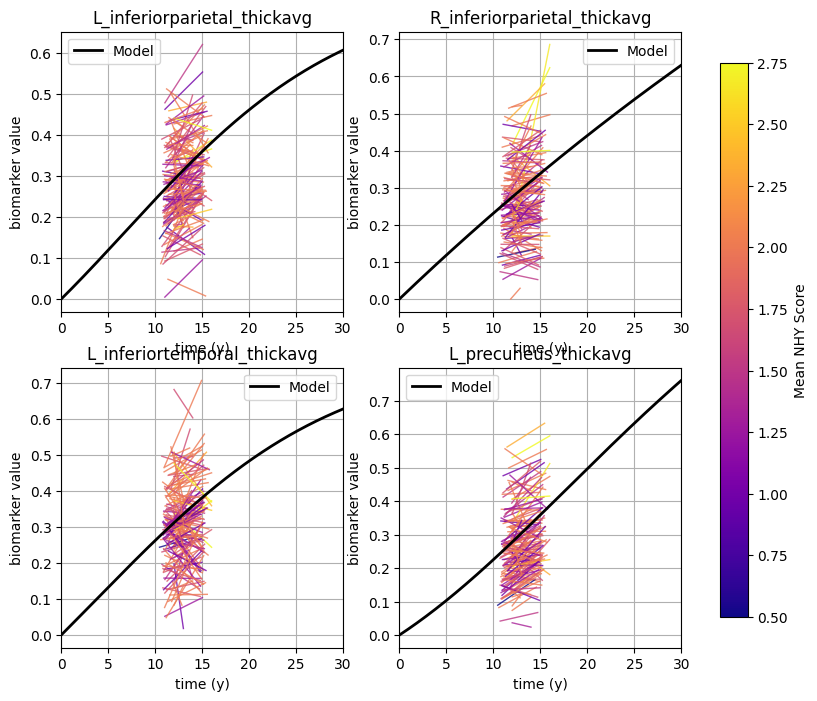

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import math
import matplotlib.cm as cm
import matplotlib.colors as colors

def plot_all_patient_regression_lines_grid_nhy(X, dt, ids, beta, t_span, nhy, model=None,
                                               biomarker_indices=None, biomarker_labels=None,
                                               max_lines=500, t_max=40):
    """
    Plot regression lines per patient for each selected biomarker on a grid of subplots.
    Each line is color-coded by the patient's mean NHY score.
    """
    if biomarker_indices is None:
        biomarker_indices = list(range(X.shape[1]))

    unique_ids = np.unique(ids)
    pid_to_index = {pid: idx for idx, pid in enumerate(unique_ids)}

    # Compute mean NHY score per patient
    mean_nhy = {}
    for pid in unique_ids:
        nhy_i = nhy[ids == pid]
        mean_nhy[pid] = np.mean(nhy_i) if len(nhy_i) > 0 else np.nan

    # Colormap setup
    cmap = cm.plasma  # or viridis, inferno, etc.
    nhy_vals = np.array(list(mean_nhy.values()))
    norm = colors.Normalize(vmin=np.nanmin(nhy_vals), vmax=np.nanmax(nhy_vals))

    n_plots = len(biomarker_indices)
    n_cols = math.ceil(np.sqrt(n_plots))
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
    axes = axes.flatten()

    for plot_idx, j in enumerate(biomarker_indices):
        ax = axes[plot_idx]
        title = biomarker_labels[j] if biomarker_labels else f"biomarker {j}"
        ax.set_title(f"{title}")
        ax.set_xlabel("time (y)")
        ax.set_ylabel("biomarker value")

        line_count = 0
        for pid in unique_ids:
            if line_count >= max_lines:
                break
            mask = (ids == pid)
            if np.sum(mask) < 2:
                continue

            X_i = X[mask, j]
            dt_i = dt[mask]
            beta_i = beta[pid_to_index[pid]]
            t_ij = dt_i + beta_i

            nhy_mean = mean_nhy[pid]
            if np.isnan(nhy_mean):
                continue
            line_color = cmap(norm(nhy_mean))

            model_i = LinearRegression().fit(t_ij.reshape(-1, 1), X_i)
            t_fit = np.linspace(t_ij.min(), t_ij.max(), 20)
            x_fit = model_i.predict(t_fit.reshape(-1, 1))

            ax.plot(t_fit, x_fit, color=line_color, alpha=0.8, linewidth=1)
            line_count += 1

        # Plot model-predicted trajectory
        if model is not None:
            ax.plot(t_span, model[j], color='black', linewidth=2, label="Model")
            ax.legend()

        ax.grid(True)
        ax.set_xlim(0, t_max)

    # Remove unused axes
    for k in range(n_plots, len(axes)):
        fig.delaxes(axes[k])

    # Add colorbar for NHY scale
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.tolist(), orientation='vertical', shrink=0.9)
    cbar.set_label("Mean NHY Score")

    plt.show()

plot_all_patient_regression_lines_grid_nhy(
    X=X_obs,
    dt=dt,
    ids=ids,
    beta=beta_history[:, -1],
    t_span=t_span,
    nhy=nhy,  # your NHY array
    model=final_model * s[:, None],
    biomarker_indices=[0, 1, 2, 4],
    biomarker_labels=small_region_set,
    max_lines=500,
    t_max=t_span[-1]
)


/tmp/ipykernel_14919/4096345311.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="NHY", y="t_ij", palette="plasma", inner="box")


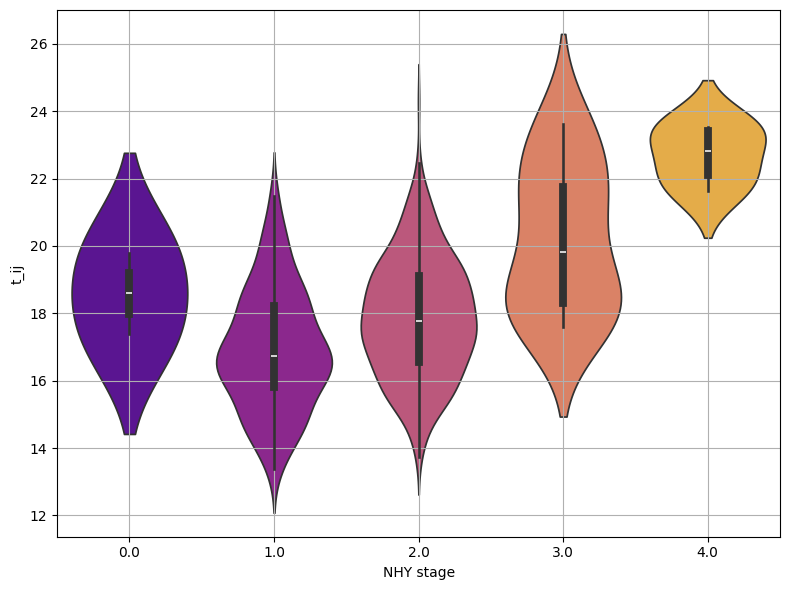

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_violin_nhy_vs_tij(dt, ids, beta, nhy):
    unique_ids = np.unique(ids)
    pid_to_index = {pid: idx for idx, pid in enumerate(unique_ids)}
    t_ij = np.array([dt_i + beta[pid_to_index[pid]] for dt_i, pid in zip(dt, ids)])

    df = pd.DataFrame({
        "t_ij": t_ij,
        "NHY": nhy
    })

    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df, x="NHY", y="t_ij", palette="plasma", inner="box")
    plt.xlabel("NHY stage")
    plt.ylabel("t_ij")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_violin_nhy_vs_tij(dt=dt, ids=ids, beta=beta_history[:, -1], nhy=nhy)


2


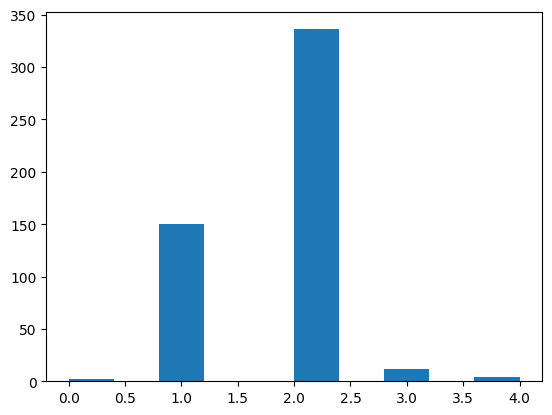

In [ ]:
plt.hist(nhy)
print(sum(nhy==0))

/tmp/ipykernel_14919/1995190623.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="NHY", y="beta", palette="plasma", inner="box")


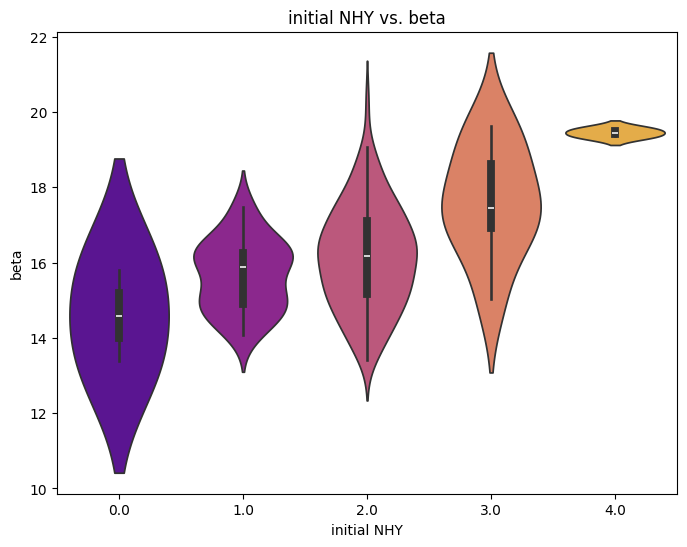

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_violin_nhy_vs_beta(ids, dt, nhy, beta):
    unique_ids = np.unique(ids)
    pair = []

    pid_to_beta = {pid: beta[i] for i, pid in enumerate(unique_ids)}

    for pid in unique_ids:
        mask = (ids == pid)
        dt_i = dt[mask]
        nhy_i = nhy[mask]
        idx_min_dt = np.argmax(dt_i)
        nhy_first = nhy_i[idx_min_dt]
        beta_i = pid_to_beta[pid]

        pair.append({"NHY": nhy_first, "beta": beta_i})

    df = pd.DataFrame(pair)

    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df, x="NHY", y="beta", palette="plasma", inner="box")
    plt.title("initial NHY vs. beta")
    plt.xlabel("initial NHY")
    plt.ylabel("beta")
    plt.show()

plot_violin_nhy_vs_beta(ids=ids, dt=dt, nhy=nhy, beta=beta_history[:, -1])
